## Updates
### 06/05
- For Majority Voting I added the logic to compute Softmax for every pixel, which gives the percentages for each of the pixels. I save them for all of the models in the ensemble, average them and then get the argmax for each of the pixels.
- Added IOU computation. I found implementations for just binary images, so I kind of adapted that to compute IOU for every single class and then averaged it out between all of the classes (I hope that that's the correct approach to working with more classes). Tested it on the random "label" and the outputs is a very small IOU, whereas if the IOU is computed between the same images it will return 1 (as it should).

### 05/05
- Initial implementation of the architecture and dataset loading


In [ ]:
from dataset_utils import CelebADataset, PixelClassificationData, visualize_dataset

In [ ]:
import gc
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Categorical
from torch.nn import Module, Linear, ReLU, BatchNorm1d, CrossEntropyLoss, Softmax

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
IMG_SIZE = 256
PIXEL_REP_DIM = 8448
NUM_CLASSES = 19

## Dataset Loading

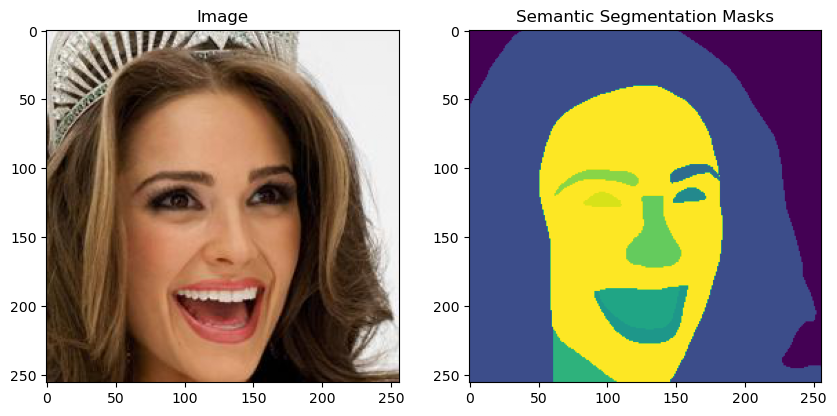

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CelebADataset("./dataset/celeba_19/real/train", transform)
test_dataset = CelebADataset("./dataset/celeba_19/real/test", transform)

train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

visualize_dataset(train_dataset, 0)

## Pixel Classification & Ensemble

In [ ]:
class PixelClassifier(Module):
    def __init__(self, input_dim, output_dim):
        super(PixelClassifier, self).__init__()

        self.dims = (input_dim, output_dim)
        self.initialize()

    ## TODO: Fix to actual initialization
    def initialize(self):
        self.act = ReLU()

        self.l1 = Linear(self.dims[0], 128)
        self.batchNorm1 = BatchNorm1d(128)

        self.l2 = Linear(128, 32)
        self.batchNorm2 = BatchNorm1d(32)

        self.output = Linear(32, self.dims[1])

    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.batchNorm1(x)

        x = self.act(self.l2(x))
        x = self.batchNorm2(x)

        return self.output(x)


In [ ]:
class Ensemble():
    def __init__(self, input_dim, output_dim, train_params):
        if 'epochs' not in train_params or 'device' not in train_params:
            raise Exception("Train Params require: 'epochs', 'device'")

        self.params = train_params
        self.models = []

        for _ in range(train_params['ensemble_num']):
            model = PixelClassifier(input_dim, output_dim)
            self.models.append(model)

    def train(self, train_data):
        for idx in range(len(self.models)):
            print(f"Ensemble Model {idx} training")
            gc.collect()

            crit = CrossEntropyLoss()

            model = self.models[idx]
            model.initialize()

            optim = Adam(model.parameters(), lr = self.params['lr'])

            model.to(self.params['device'])
            model.train()

            for epoch in range(self.params['epochs']):

                running_loss = 0.
                for inputs, labels in tqdm(train_data):
                    inputs, labels = inputs.to(self.params['device']), labels.to(self.params['device'])

                    inputs = inputs.to(self.params['device'])
                    optim.zero_grad()
                    outputs = model(inputs)


                    loss = crit(outputs, labels)
                    loss.backward()
                    optim.step()

                    running_loss += loss.item()
                print(f"Loss: {running_loss / len(train_data)}\n")

                ## TODO: BREAKING if plateaus (no need to run for 100 epochs)

            if self.params['device'].type == 'cuda':
                self.models[idx] = model.to(torch.device("cpu"))
            else:
                self.models[idx] = model

    def prediction(self, pixels):
        softmax = Softmax(dim = 1)
        num_models = len(self.models)

        pixels = X_input.to(self.params['device'])

        probs = torch.zeros((IMG_SIZE * IMG_SIZE, NUM_CLASSES))

        for idx in range(num_models):
            gc.collect()

            model = self.models[idx].to(self.params['device'])
            model.eval()

            output = model(pixels).cpu()

            probs += softmax(output)

        avg_probs = probs / num_models
        pred_seg = torch.max(avg_probs, dim = 1).indices

        return pred_seg.reshape((IMG_SIZE, IMG_SIZE)).numpy()

    def save(self):
        pass

## Evaluation

In [ ]:
def IOU_metric(labels, preds):
    ious = []
    for label, pred in zip(labels, preds):
        intersections, unions = [], []
        for _class in range(NUM_CLASSES):
            mask_label = (label == _class).astype(np.uint8)
            mask_pred  = (pred == _class).astype(np.uint8)

            intersection = np.sum(np.logical_and(mask_label, mask_pred))
            intersections.append(intersection)

            union = np.sum(np.logical_or(mask_label, mask_pred))
            unions.append(union)


        total_iou = 0.0
        for _class in range(NUM_CLASSES):
            intersection, union = intersections[_class], unions[_class]

            if intersection == union:
                total_iou += 1.0
            else:
                total_iou += intersection / union if union > 0 else 0.0

        ious.append(total_iou / NUM_CLASSES)

    return np.mean(np.array(ious))

## Main

In [ ]:
## TODO: Change to Actual Features from UNET (Debugging)
X = torch.rand((1, PIXEL_REP_DIM, IMG_SIZE, IMG_SIZE), dtype=torch.float)
y = train_dataset[0][1].unsqueeze(0) ##torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.uint8)

X_input = X.permute(1,0,2,3).reshape(X.shape[1], -1).permute(1, 0)
y_input = y.flatten()

pixel_train_dataset = PixelClassificationData(X_input, y_input)
pixel_train_loader = DataLoader(pixel_train_dataset, batch_size = 64, shuffle = True)

In [ ]:
train_params = {
    'ensemble_num' : 1, ## TODO:
    'lr' : 1e-3,
    'epochs': 1, ## TODO:
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

ensemble = Ensemble(PIXEL_REP_DIM, NUM_CLASSES, train_params)
ensemble.train(pixel_train_loader)

In [ ]:
## TODO: Convert last cell to prediction function with all components

with torch.no_grad():
    labels, preds = [], []
    for i in tqdm(range(len(train_dataset))):
        image, label = train_dataset[i]

        labels.append(label.numpy())

        #### TODO: EXTRACT FEATURES (random noise for testing purposes) ######################################
        X = torch.rand((1, PIXEL_REP_DIM, IMG_SIZE, IMG_SIZE), dtype=torch.float)
        y = label.unsqueeze(0)

        X_input = X.permute(1,0,2,3).reshape(X.shape[1], -1).permute(1, 0)
        y_input = y.flatten()
        ######################################################################################################

        pred_segmentation = ensemble.prediction(X_input)
        preds.append(pred_segmentation)

        if i == 2: break ## TODO: Debugging

    avg_iou = IOU_metric(labels, preds)
    print(avg_iou)

 10%|████████▎                                                                          | 2/20 [00:12<01:53,  6.28s/it]

0.2631578947368421


In [ ]:
IOU_metric(labels, labels) ## TODO: Testing (should return 1.0)

1.0